### Imports and Definitions

In [1]:
from glob import glob
from math import log10
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import makedirs
from os.path import isfile
from seaborn import pointplot, set_context, set_style, violinplot
import matplotlib.pyplot as plt
ZERO_THRESH = 0.0000000001
TIME_ZERO = 0.001
DATADIR = '../data'
FIGDIR = '../figs'; makedirs(FIGDIR, exist_ok=True)
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'
rcParams['patch.edgecolor'] = '4C4C4C' # set boxenplot outlines same as violinplot
TOOLS = ['nx', 'ig', 'ngg']
MODELS_EDX = {'complete'}
meta = {
    'color': {
        'ig': 'blue',
        'ngg': 'green',
        'nx': 'red',
    },
    
    'linestyle': {
        'ig': '--',
        'ngg': '-',
        'nx': ':',
    },
    
    'label': {
        'ba': 'Barabási–Albert',
        'complete': 'Complete',
        'er': 'Erdős–Rényi',
        'ig': 'iGraph',
        'ngg': 'NiemaGraphGen',
        'nws': 'Newman–Watts–Strogatz',
        'nx': 'NetworkX',
    },
}

### Helper: Convert Power of 10 to Scientific Notation

In [2]:
def sci_not_mult10(n):
    p = log10(n)
    assert abs(p-int(p)) < ZERO_THRESH, "Not a power of 10: %s" % n
    return r'$10^%d$' % p

### Helper: Get Walltime (seconds) from GNU `time` Output

In [3]:
def walltime_from_time(path):
    tl = [l.strip().split()[-1].strip() for l in open(path) if l.strip().startswith('Elapsed (wall clock) time (h:mm:ss or m:ss)')]
    assert len(tl) == 1, "Multiple lines starting with 'Elapsed (wall clock) time' in: %s" % path
    parts = tl[0].split(':')
    if len(parts) == 3: # h:mm:ss
        return float(parts[0])*3600 + float(parts[1])*60 + float(parts[2])
    elif len(parts) == 2: # m:ss
        return float(parts[0])*60 + float(parts[1])
    else:
        assert False, "Invalid time: %s" % tl[0]

### Helper: Get Peak Memory from GNU `time` Output

In [4]:
def peak_memory_from_time(path):
    tl = [l.strip().split()[-1].strip() for l in open(path) if l.strip().startswith('Maximum resident set size (kbytes)')]
    assert len(tl) == 1, "Multiple lines starting with 'Maximum resident set size (kbytes)' in: %s" % path
    return int(tl[0])

### Plot Runtime vs. *n*

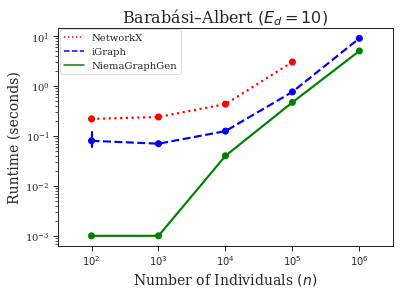

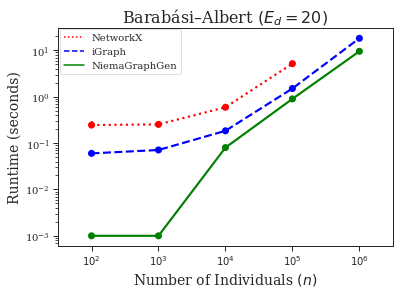

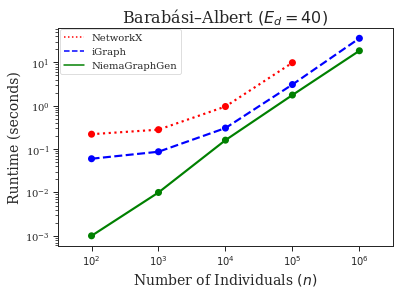

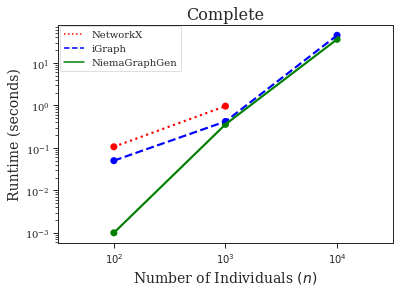

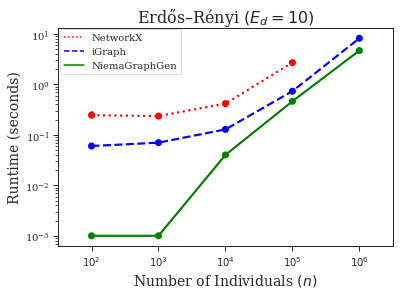

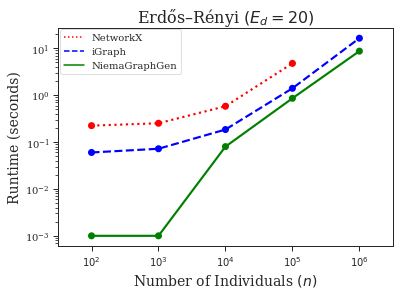

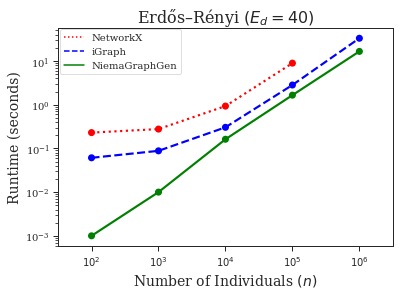

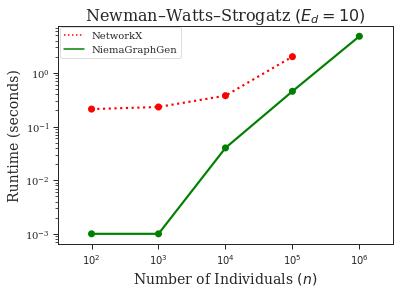

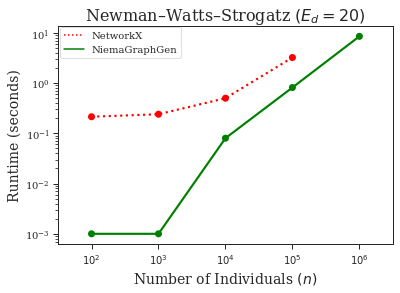

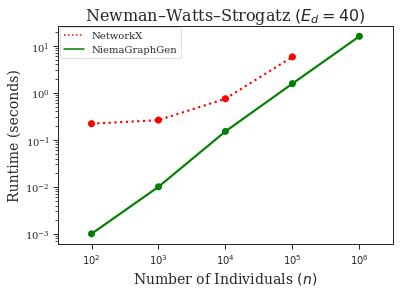

In [5]:
for model in sorted(set(f.split('/')[-1].split('.')[1] for f in glob('%s/n*/ed*/time.*' % DATADIR))):
    for ed in sorted(set(f.split('/')[-1].lstrip('ed') for f in glob('%s/n*/ed*' % DATADIR))):
        if ed == 'X':
            if model not in MODELS_EDX:
                continue
            title = meta['label'][model]
            fn = '%s/time.%s.pdf' % (FIGDIR,model)
        else:
            if model in MODELS_EDX:
                continue
            title = r'%s $\left(E_d=%s\right)$' % (meta['label'][model], ed)
            fn = '%s/time.%s.ed%s.pdf' % (FIGDIR,model,ed)
        fig, ax = plt.subplots(); handles = list()
        for tool in TOOLS:
            x = list(); y = list() # x = n; y = time
            for ndir in sorted(glob('%s/n*' % DATADIR)):
                n = int(ndir.split('/')[-1].lstrip('n'))
                for time_rep in sorted(glob('%s/ed%s/time.%s.%s.*' % (ndir,ed,model,tool))):
                    t = max(walltime_from_time(time_rep), TIME_ZERO)
                    y.append(t); x.append(sci_not_mult10(n))
            if len(x) != 0:
                handles.append(Line2D([0],[0],color=meta['color'][tool],label=meta['label'][tool],linewidth=1.5,linestyle=meta['linestyle'][tool]))
                pointplot(x=x, y=y, color=meta['color'][tool], linestyles=meta['linestyle'][tool])
        plt.xlabel(r'Number of Individuals $\left(n\right)$')
        plt.ylabel('Runtime (seconds)')
        plt.title(title)
        ax.set_yscale('log')
        plt.legend(handles=handles,bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0., frameon=True)
        fig.savefig(fn, format='pdf', bbox_inches='tight')

### Plot Peak Memory vs. *n*

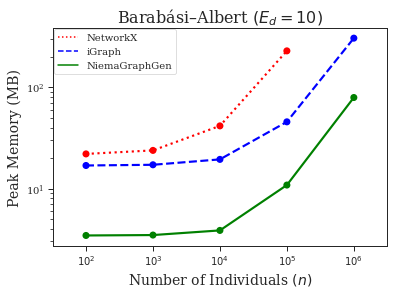

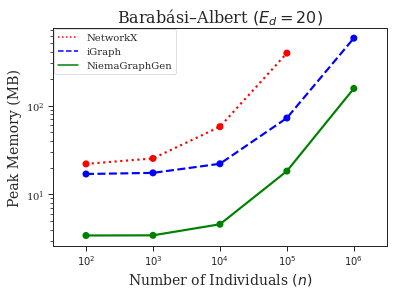

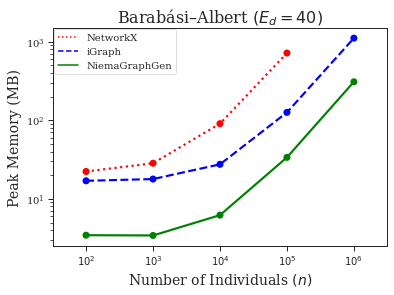

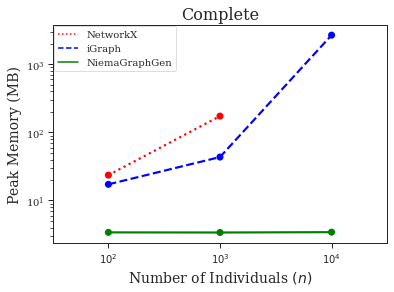

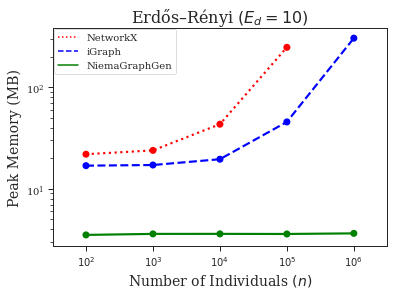

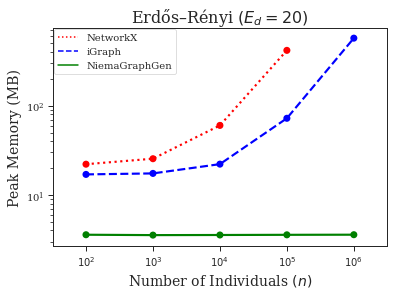

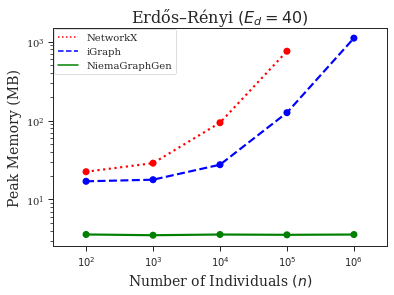

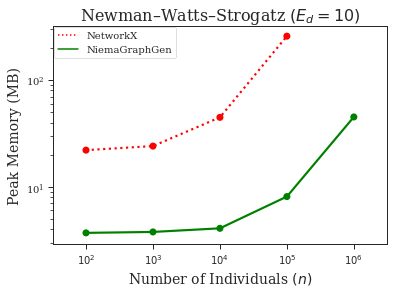

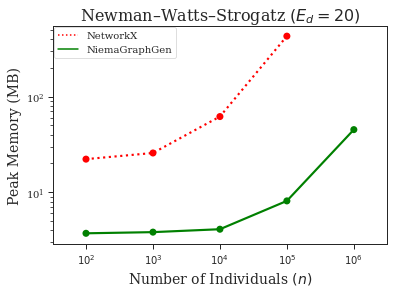

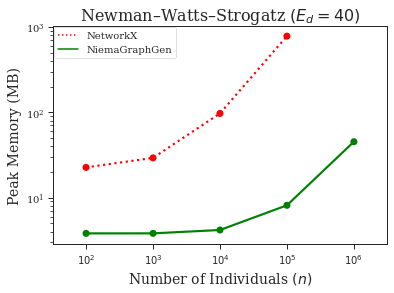

In [6]:
for model in sorted(set(f.split('/')[-1].split('.')[1] for f in glob('%s/n*/ed*/time.*' % DATADIR))):
    for ed in sorted(set(f.split('/')[-1].lstrip('ed') for f in glob('%s/n*/ed*' % DATADIR))):
        if ed == 'X':
            if model not in MODELS_EDX:
                continue
            title = meta['label'][model]
            fn = '%s/memory.%s.pdf' % (FIGDIR,model)
        else:
            if model in MODELS_EDX:
                continue
            title = r'%s $\left(E_d=%s\right)$' % (meta['label'][model], ed)
            fn = '%s/memory.%s.ed%s.pdf' % (FIGDIR,model,ed)
        fig, ax = plt.subplots(); handles = list()
        for tool in TOOLS:
            x = list(); y = list() # x = n; y = peak memory
            for ndir in sorted(glob('%s/n*' % DATADIR)):
                n = int(ndir.split('/')[-1].lstrip('n'))
                for time_rep in sorted(glob('%s/ed%s/time.%s.%s.*' % (ndir,ed,model,tool))):
                    m = peak_memory_from_time(time_rep)
                    y.append(m/1024); x.append(sci_not_mult10(n))
            if len(x) != 0:
                handles.append(Line2D([0],[0],color=meta['color'][tool],label=meta['label'][tool],linewidth=1.5,linestyle=meta['linestyle'][tool]))
                pointplot(x=x, y=y, color=meta['color'][tool], linestyles=meta['linestyle'][tool])
        plt.xlabel(r'Number of Individuals $\left(n\right)$')
        plt.ylabel('Peak Memory (MB)')
        plt.title(title)
        ax.set_yscale('log')
        plt.legend(handles=handles,bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0., frameon=True)
        fig.savefig(fn, format='pdf', bbox_inches='tight')